In [1]:
import os
os.environ['MKL_NUM_THREADS'] = '2'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sb
import theano
import theano.tensor as tt

%matplotlib inline

In [3]:
counts = pd.read_csv('pasilla_gene_counts.tsv', sep='\t', index_col=0)

In [4]:
counts.head()

,untreated1,untreated2,untreated3,untreated4,treated1,treated2,treated3
gene_id,,,,,,,
FBgn0000003,0,0,0,0,0,0,1
FBgn0000008,92,161,76,70,140,88,70
FBgn0000014,5,1,0,0,4,0,0
FBgn0000015,0,2,1,2,1,0,0
FBgn0000017,4664,8714,3564,3150,6205,3072,3334


In [5]:
is_treated = np.array([False] * 4 + [True] * 3)

In [6]:
counts = counts[counts.sum(1) > 500]

In [7]:
len(counts)

6665

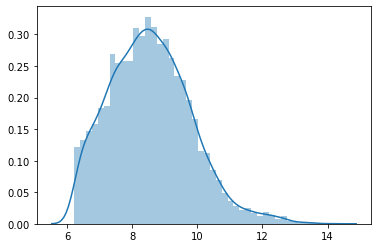

In [8]:
sb.distplot(np.log(counts.sum(1)))

In [9]:
counts = counts.head(200)

In [11]:
class ExpModNormal(pm.Continuous):
    def __init__(self, mu, sd, lambda_, *args, **kwargs):
        super(ExpModNormal, self).__init__(*args, **kwargs)
        self.mu = mu = tt.as_tensor_variable(mu)
        self.sd = sd = tt.as_tensor_variable(sd)
        self.lambda_ = lambda_ = tt.as_tensor_variable(lambda_)
        self.mean = mu + 1 / lambda_

    def logp(self, value):
        mu, sd, lambda_ = self.mu, self.sd, self.lambda_
        tmp = mu + sd * sd * lambda_ - value
        return (tt.log(lambda_ / 2)
            + lambda_ * (tmp - sd * sd * lambda_ / 2)
            + tt.log(tt.erfc(tmp / (np.sqrt(2) * sd))))

In [12]:
n_genes, n_samples = counts.shape

with pm.Model() as model:
    gene = pm.Normal('gene', shape=n_genes, mu=8, sd=5,
                     testval=np.log(counts + 1).mean(1).values.ravel())
    
    #sample_raw = pm.Flat('sample_raw', shape=n_samples - 1,
    #                     testval=np.log(counts + 1).mean().values.ravel()[:-1]
    #                             - np.log(counts + 1).mean().mean())
    #sample_last = - sample_raw.sum()
    #sample = tt.concatenate([sample_raw, sample_last.reshape((1,))])
    #pm.Deterministic('sample', sample)
    
    # This is the source of quite some correcation. Reparametrization would help.
    sample_ps = np.log(counts + 1).mean().values.ravel() - np.log(counts + 1).mean().mean()
    sample = pm.Normal('sample', shape=n_samples, testval=sample_ps)
    
    pm.Potential('sample_pot', pm.Normal.dist(mu=0, sd=3).logp(sample))
    
    mu = pm.Normal('gene_sample_lsd_mu', mu=-3, sd=1)
    sd = pm.Bound(pm.HalfNormal, lower=0.05, upper=3)('gene_sample_lsd_sd', sd=0.3)
    #sd = pm.HalfNormal('gene_sample_lsd_sd', sd=0.3)
    
    lambda_inv = pm.HalfNormal('gene_sample_lsd_lambda_inv', sd=1)
    #gene_sample_lsd = ExpModNormal('gene_sample_lsd', mu=mu, sd=sd,
    #                               lambda_=1/lambda_inv, shape=n_genes)
    gene_sample_lsd = ExpModNormal('gene_sample_lsd', mu=0, sd=1,
                                   lambda_=1/lambda_inv, shape=n_genes)
    gene_sample_lsd = gene_sample_lsd * sd + mu

    gene_sample_sd = tt.exp(gene_sample_lsd)
    pm.Deterministic('gene_sample_sd', gene_sample_sd)
    
    # Sparse prior for the effects
    #tau = pm.HalfStudentT('effect_tau', nu=3, sd=0.1, testval=0.01)
    #c = pm.InverseGamma('effect_c', alpha=2.5, beta=10)
    #theta_raw = pm.Uniform('effect_theta_raw', lower=0, upper=np.pi / 2, shape=n_genes)
    #theta = tt.tan(theta_raw)
    #lmbda = c * theta / tt.sqrt(c ** 2 + tau ** 2 * theta ** 2)
    #eta = pm.Normal('effect_eta', shape=n_genes)
    #effect = tau * lmbda * eta
    #pm.Deterministic('effect', effect)
    
    effect_sd = pm.HalfNormal('effect_sd', sd=1)
    effect = pm.Normal('effect', mu=0, sd=effect_sd, shape=n_genes)

    mu = gene[:, None] + sample[None, :] + effect[:, None] * (is_treated - 0.5)
    pm.Deterministic('mu', mu)

    gene_sample = pm.StudentT('gene_sample', nu=7, mu=mu,
                              sd=gene_sample_sd[:, None],
                              shape=(n_genes, n_samples))

    pm.Poisson('counts', log_mu=gene_sample, observed=counts)

In [13]:
model.ndim

2011

In [14]:
with model:
    trace = pm.sample(
        #chains=4, init='advi+adapt_diag', tune=1000,
        chains=4, tune=1000,
        draws=10000, cores=2, target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [gene_sample, effect, effect_sd, gene_sample_lsd, gene_sample_lsd_lambda_inv, gene_sample_lsd_sd, gene_sample_lsd_mu, sample, gene]
Sampling 4 chains: 100%|██████████| 44000/44000 [07:43<00:00, 94.92draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7476145772523849, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8279517685097045, but should be close to 0.9. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
import covadapt.eigvals_lw
import covadapt.potential

In [16]:
with model:
    pot = covadapt.potential.EigvalsAdapt(
        model.ndim,
        np.zeros(model.ndim),
        covadapt.eigvals_lw.eigh_lw_samples_grads,
        eigvalsfunc_kwargs=dict(
            n_eigs=15,
            n_eigs_grad=15,
            n_final=30,
        ),
        display=True,
        adaptation_window=200,
    )

    step = pm.NUTS(potential=pot, target_accept=0.9)
    trace2 = pm.sample(step=step, draws=10000, tune=1100, chains=4, cores=2)

Multiprocess sampling (4 chains in 2 jobs)
NUTS: [gene_sample, effect, effect_sd, gene_sample_lsd, gene_sample_lsd_lambda_inv, gene_sample_lsd_sd, gene_sample_lsd_mu, sample, gene]
Sampling 4 chains:   2%|▏         | 800/44400 [01:41<2:23:31,  5.06draws/s]

n_samples 200
n_samples 200
Finding eigenvalues took 1.1746315956115723s
eigvals [1.47157026e-03 1.48963208e-03 1.59104501e-03 1.70331753e-03
 1.78330877e-03 2.03368998e-03 2.16844915e-03 7.88616054e-03
 8.37557688e-03 8.85688218e-03 9.14269878e-03 9.66790963e-03
 9.70844243e-03 9.98723597e-03 1.01613055e-02 1.20246756e+01
 1.21974614e+01 1.30496125e+01 1.34075563e+01 1.45040254e+01
 1.47843392e+01 1.59019183e+01 1.66534974e+01 1.69658055e+01
 1.91606019e+01 2.04328763e+01 2.12651609e+01 2.43730878e+01
 2.95806224e+01 3.03162513e+02]
Finding eigenvalues took 1.0274019241333008s
eigvals [1.74365723e-03 1.90257122e-03 1.94941626e-03 2.03708601e-03
 2.45990716e-03 2.46412702e-03 3.06885726e-03 9.11388662e-03
 9.66122756e-03 1.02061080e-02 1.06488250e-02 1.08882246e-02
 1.11932901e-02 1.15123903e-02 1.16016645e-02 8.01750804e+00
 8.12459681e+00 8.46382426e+00 8.86456694e+00 9.22700190e+00
 9.47969538e+00 9.71678459e+00 1.05856094e+01 1.09396521e+01
 1.15601845e+01 1.33008113e+01 1.35186067

Sampling 4 chains:   3%|▎         | 1164/44400 [02:03<21:21, 33.73draws/s] 

n_samples 200


Sampling 4 chains:   3%|▎         | 1168/44400 [02:04<27:58, 25.76draws/s]

Finding eigenvalues took 0.2929673194885254s
eigvals [1.35320984e-03 1.51143418e-03 1.54190444e-03 1.61884228e-03
 1.96197042e-03 2.16176234e-03 2.30100248e-03 9.35056646e-03
 1.04054618e-02 1.11533746e-02 1.12782282e-02 1.15399212e-02
 1.22993643e-02 1.24847522e-02 1.41520600e-02 1.85138549e+01
 1.98433037e+01 1.99780840e+01 2.01828348e+01 2.16550563e+01
 2.23886417e+01 2.29829442e+01 2.33538493e+01 2.39690546e+01
 2.51152738e+01 2.67156037e+01 2.78993420e+01 2.87156983e+01
 2.97458914e+01 2.28549938e+02]


Sampling 4 chains:   3%|▎         | 1218/44400 [02:05<20:49, 34.57draws/s]

n_samples 200


Sampling 4 chains:   3%|▎         | 1222/44400 [02:05<22:40, 31.74draws/s]

Finding eigenvalues took 0.22380590438842773s
eigvals [4.63914084e-04 5.36238150e-04 5.83234431e-04 6.72822103e-04
 7.04188132e-04 7.82177601e-04 8.37622585e-04 3.53325597e-03
 3.80590687e-03 3.92643310e-03 4.05356155e-03 4.29084724e-03
 4.33498178e-03 4.43019782e-03 4.57444503e-03 1.84606008e+01
 1.91728529e+01 1.93347878e+01 2.02990049e+01 2.11112467e+01
 2.19053974e+01 2.24568345e+01 2.28376810e+01 2.34872090e+01
 2.44124038e+01 2.59485246e+01 2.69371376e+01 3.07048712e+01
 3.22928206e+01 1.82545940e+02]


Sampling 4 chains:   3%|▎         | 1530/44400 [02:14<23:12, 30.78draws/s]

n_samples 200


Sampling 4 chains:   3%|▎         | 1534/44400 [02:14<25:11, 28.36draws/s]

Finding eigenvalues took 0.21512436866760254s
eigvals [7.38467450e-04 7.77658930e-04 8.61542810e-04 9.64693410e-04
 1.01636381e-03 1.12445887e-03 1.48372905e-03 5.90035364e-03
 6.24493263e-03 6.57544104e-03 6.80158897e-03 7.22585000e-03
 7.37445735e-03 7.56403986e-03 7.98777705e-03 2.16545289e+01
 2.18016337e+01 2.25063610e+01 2.29121000e+01 2.37055042e+01
 2.45501608e+01 2.48398351e+01 2.51490503e+01 2.62686890e+01
 2.65817401e+01 2.76462919e+01 2.96739748e+01 3.08807020e+01
 3.10924980e+01 1.75516483e+02]


Sampling 4 chains:   4%|▍         | 1669/44400 [02:19<24:10, 29.46draws/s]

n_samples 200


Sampling 4 chains:   4%|▍         | 1672/44400 [02:19<26:53, 26.48draws/s]

Finding eigenvalues took 0.2200760841369629s
eigvals [4.33700181e-04 4.52899363e-04 4.79859170e-04 5.24400131e-04
 5.55847298e-04 6.35287590e-04 7.44722272e-04 3.31399865e-03
 3.38310210e-03 3.59903422e-03 3.61484013e-03 3.73469128e-03
 3.89179327e-03 3.95330965e-03 4.26677794e-03 2.02695711e+01
 2.04839740e+01 2.12773111e+01 2.19109097e+01 2.34285064e+01
 2.50321244e+01 2.55399129e+01 2.63940024e+01 2.66980634e+01
 2.96712681e+01 3.01109378e+01 3.27560145e+01 3.43152668e+01
 3.73434598e+01 1.39688528e+02]


Sampling 4 chains:   4%|▍         | 1919/44400 [02:28<20:51, 33.93draws/s]

n_samples 200


Sampling 4 chains:   4%|▍         | 1923/44400 [02:28<22:09, 31.94draws/s]

Finding eigenvalues took 0.25924205780029297s
eigvals [4.88037855e-04 5.41911593e-04 5.69634985e-04 5.88320138e-04
 6.61132484e-04 7.03168928e-04 8.82401512e-04 4.05446925e-03
 4.25557084e-03 4.52704679e-03 4.67591587e-03 4.71026890e-03
 4.94758822e-03 5.14688951e-03 5.22355394e-03 2.40672822e+01
 2.47334940e+01 2.54863773e+01 2.63655237e+01 2.68209572e+01
 2.72498321e+01 2.79679213e+01 2.85648482e+01 3.05883373e+01
 3.22111315e+01 3.47277894e+01 3.66225439e+01 3.85014604e+01
 4.21472610e+01 1.94703443e+02]


Sampling 4 chains:   5%|▍         | 2080/44400 [02:34<30:27, 23.16draws/s]

n_samples 200


Sampling 4 chains:   5%|▍         | 2083/44400 [02:35<31:21, 22.49draws/s]

Finding eigenvalues took 0.23919057846069336s
eigvals [4.88857522e-04 5.83910089e-04 6.23478081e-04 6.76478374e-04
 7.68046823e-04 9.02777924e-04 1.01031662e-03 4.09035819e-03
 4.58466262e-03 4.62044877e-03 4.89024035e-03 5.05853631e-03
 5.12681135e-03 5.30162165e-03 5.61130665e-03 1.99415756e+01
 2.03974340e+01 2.16341940e+01 2.18784660e+01 2.23915369e+01
 2.29319045e+01 2.39704505e+01 2.50569637e+01 2.53868813e+01
 2.60548486e+01 2.69811177e+01 2.79866542e+01 3.33555311e+01
 3.76428323e+01 1.32467298e+02]


Sampling 4 chains:  52%|█████▏    | 22993/44400 [16:53<1:07:09,  5.31draws/s]

n_samples 200


Sampling 4 chains:  52%|█████▏    | 22996/44400 [16:54<1:50:40,  3.22draws/s]

Finding eigenvalues took 1.0326650142669678s
eigvals [2.06683843e-03 2.34048454e-03 2.52644497e-03 2.74094418e-03
 3.21780718e-03 3.27915994e-03 3.68364688e-03 8.22348168e-03
 1.16595912e-02 1.29685146e-02 1.30575599e-02 1.41444276e-02
 1.45704207e-02 1.52978254e-02 1.57939471e-02 7.16320845e+00
 7.60131644e+00 7.90424372e+00 8.01621775e+00 8.48643140e+00
 8.71925749e+00 9.78426520e+00 1.00794262e+01 1.03045353e+01
 1.22905793e+01 1.36231337e+01 1.41225281e+01 1.45360754e+01
 2.26634208e+01 4.67186638e+01]


Sampling 4 chains:  52%|█████▏    | 23004/44400 [16:56<1:16:37,  4.65draws/s]

n_samples 200


Sampling 4 chains:  52%|█████▏    | 23006/44400 [16:57<2:12:53,  2.68draws/s]

Finding eigenvalues took 1.1068742275238037s
eigvals [1.03514707e-03 1.23624863e-03 1.35454326e-03 1.42970517e-03
 1.62040932e-03 1.85107211e-03 2.02763564e-03 6.64109631e-03
 7.07157411e-03 7.42892604e-03 7.93111877e-03 8.09012868e-03
 8.33126150e-03 8.67813186e-03 8.82572497e-03 9.07755637e+00
 9.20151849e+00 9.51251547e+00 1.00214181e+01 1.07097610e+01
 1.09480627e+01 1.12945166e+01 1.15737902e+01 1.22037359e+01
 1.24009628e+01 1.32000001e+01 1.44022139e+01 1.51617260e+01
 1.68491201e+01 9.17268223e+01]


Sampling 4 chains:  52%|█████▏    | 23301/44400 [17:14<25:46, 13.65draws/s]  

n_samples 200


Sampling 4 chains:  52%|█████▏    | 23304/44400 [17:14<24:10, 14.54draws/s]

Finding eigenvalues took 0.3141751289367676s
eigvals [1.56265111e-03 1.65392712e-03 2.07211765e-03 2.09990289e-03
 2.46571098e-03 2.67237764e-03 2.98440028e-03 1.13687204e-02
 1.25116394e-02 1.29731789e-02 1.33893951e-02 1.41772137e-02
 1.47896343e-02 1.56315854e-02 1.69962162e-02 1.74896722e+01
 1.79728288e+01 1.85891984e+01 1.96911189e+01 1.97631603e+01
 2.03778830e+01 2.11233381e+01 2.11445124e+01 2.19425741e+01
 2.32396825e+01 2.49362122e+01 2.50778331e+01 2.62457200e+01
 2.99884893e+01 1.96792659e+02]


Sampling 4 chains:  53%|█████▎    | 23540/44400 [17:21<15:22, 22.60draws/s]

n_samples 200


Sampling 4 chains:  53%|█████▎    | 23543/44400 [17:22<17:55, 19.38draws/s]

Finding eigenvalues took 0.29654359817504883s
eigvals [9.50898700e-04 1.13514866e-03 1.19243567e-03 1.42253016e-03
 1.62682733e-03 1.69908758e-03 1.92632885e-03 7.84844527e-03
 8.19546255e-03 8.69178360e-03 9.04938222e-03 9.35570455e-03
 9.77766938e-03 9.91078578e-03 1.09433840e-02 1.60346180e+01
 1.66347395e+01 1.67511012e+01 1.74871731e+01 1.75707209e+01
 1.90572593e+01 1.93710265e+01 2.05517898e+01 2.20782111e+01
 2.26200721e+01 2.38999631e+01 2.51390932e+01 2.60961341e+01
 2.80655854e+01 1.37641801e+02]


Sampling 4 chains:  53%|█████▎    | 23636/44400 [17:24<12:17, 28.14draws/s]

n_samples 200


Sampling 4 chains:  53%|█████▎    | 23639/44400 [17:25<17:08, 20.20draws/s]

Finding eigenvalues took 0.2427208423614502s
eigvals [7.71293456e-04 8.94731733e-04 9.84499114e-04 1.00246614e-03
 1.16447867e-03 1.45959963e-03 1.57675388e-03 6.06810516e-03
 6.11756156e-03 6.38972253e-03 6.59982183e-03 7.02640276e-03
 7.11613476e-03 7.46701160e-03 7.76831064e-03 2.04566008e+01
 2.11817854e+01 2.13984324e+01 2.23456639e+01 2.27454258e+01
 2.30913784e+01 2.33164481e+01 2.42012172e+01 2.43104826e+01
 2.53213041e+01 2.55403479e+01 2.72800624e+01 3.24550116e+01
 4.65921190e+01 1.38918879e+02]


Sampling 4 chains:  54%|█████▍    | 23947/44400 [17:35<11:55, 28.59draws/s]

n_samples 200


Sampling 4 chains:  54%|█████▍    | 23950/44400 [17:35<16:32, 20.60draws/s]

Finding eigenvalues took 0.2278728485107422s
eigvals [6.33830624e-04 6.65618111e-04 7.54725322e-04 7.92864021e-04
 9.16775801e-04 9.56247313e-04 1.01826176e-03 5.29763831e-03
 5.42902088e-03 5.53056166e-03 5.75177382e-03 5.95977212e-03
 6.13450858e-03 6.26479312e-03 6.29235057e-03 2.43516827e+01
 2.50162057e+01 2.51979846e+01 2.54938287e+01 2.65629840e+01
 2.71582730e+01 2.78151312e+01 2.82564652e+01 2.90700540e+01
 2.93301420e+01 3.10136950e+01 3.15510889e+01 3.36462984e+01
 3.63943336e+01 2.27844251e+02]


Sampling 4 chains:  54%|█████▍    | 24051/44400 [17:39<12:07, 27.98draws/s]

n_samples 200


Sampling 4 chains:  54%|█████▍    | 24054/44400 [17:39<14:21, 23.62draws/s]

Finding eigenvalues took 0.24172163009643555s
eigvals [7.38563626e-04 8.13218087e-04 9.24973217e-04 1.02950547e-03
 1.13888768e-03 1.21901675e-03 1.54841178e-03 6.28339877e-03
 6.37068143e-03 6.51592529e-03 7.00459608e-03 7.14543010e-03
 7.49059139e-03 7.57610887e-03 7.81007317e-03 2.21889183e+01
 2.34815836e+01 2.39071756e+01 2.41614644e+01 2.51096199e+01
 2.58731117e+01 2.64820507e+01 2.69902282e+01 2.83297685e+01
 3.00312756e+01 3.08549946e+01 3.32606682e+01 3.57349560e+01
 4.50651160e+01 1.57764355e+02]


Sampling 4 chains:  55%|█████▍    | 24344/44400 [17:49<11:42, 28.53draws/s]

n_samples 200


Sampling 4 chains:  55%|█████▍    | 24347/44400 [17:49<15:12, 21.97draws/s]

Finding eigenvalues took 0.2394237518310547s
eigvals [4.54258137e-04 5.48608055e-04 5.71727762e-04 6.06772921e-04
 7.08996831e-04 8.09277550e-04 8.60569636e-04 3.56300551e-03
 3.91179152e-03 4.03444831e-03 4.21429584e-03 4.35539638e-03
 4.44811285e-03 4.78495366e-03 4.88265521e-03 2.00816800e+01
 2.05505463e+01 2.16013819e+01 2.33219930e+01 2.35526991e+01
 2.40805544e+01 2.53209033e+01 2.59761430e+01 2.69129986e+01
 2.81463484e+01 3.31454005e+01 3.43843598e+01 3.89414508e+01
 4.09879248e+01 1.35379913e+02]


Sampling 4 chains: 100%|██████████| 44400/44400 [30:30<00:00, 24.26draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [17]:
{var: vals.min() for var, vals in pm.effective_n(trace).items()}

{'gene': 19.92612571253052,
 'sample': 19.69788747678697,
 'gene_sample_lsd_mu': 3464.3008901211438,
 'gene_sample_lsd': 1033.1764728873,
 'effect': 12049.495547532724,
 'gene_sample': 35911.10446998285,
 'gene_sample_lsd_sd': 1087.6211027125964,
 'gene_sample_lsd_lambda_inv': 833.1365819909495,
 'gene_sample_sd': 10041.621918169738,
 'effect_sd': 13297.60326995302,
 'mu': 14432.907079381788}

In [18]:
{var: vals.min() for var, vals in pm.effective_n(trace2).items()}

{'gene': 5672.829160180391,
 'sample': 5656.255147509085,
 'gene_sample_lsd_mu': 6157.971760202753,
 'gene_sample_lsd': 1466.8657673729417,
 'effect': 14234.73261492884,
 'gene_sample': 38121.153846943074,
 'gene_sample_lsd_sd': 1295.6743698704224,
 'gene_sample_lsd_lambda_inv': 1233.459312944194,
 'gene_sample_sd': 12967.320579218374,
 'effect_sd': 15345.154223053476,
 'mu': 17522.739692205178}

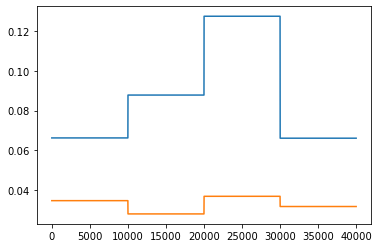

In [19]:
plt.plot(trace['step_size'])
plt.plot(trace2['step_size'])

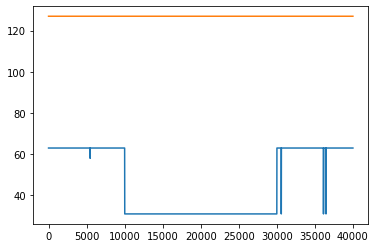

In [20]:
plt.plot(trace['tree_size'])
plt.plot(trace2['tree_size'])